### Levantar y standarizar los datos

In [1]:
import pandas as pd
df_completo = pd.read_csv("dataset_con_fechas_actualizado.csv")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3936\3338748881.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_completo = pd.read_csv("dataset_con_fechas_actualizado.csv")


In [2]:
# Convertir la columna 'sale_date' a datetime
df_completo['sale_date'] = pd.to_datetime(df_completo['sale_date'], errors='coerce')

# Verificar si la conversión fue exitosa
print(df_completo['sale_date'].dtype)

datetime64[ns]


In [3]:
# Limpiar las columnas "State Bottle Cost", "State Bottle Retail" y "Sale (Dollars)"
for col in ['State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)']:
    df_completo[col] = df_completo[col].replace('[\$,]', '', regex=True).astype(float)

# Verificar que las conversiones se realizaron correctamente
print(df_completo[['State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)']].dtypes)


State Bottle Cost      float64
State Bottle Retail    float64
Sale (Dollars)         float64
dtype: object


In [4]:
df_completo.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)',
       'sale_date', 'Month'],
      dtype='object')

### Filtrar por botella y descartar variables

In [ ]:
# Filtrar el dataset para conservar solo las 4 botellas elegidas
botellas_interes = [375, 750, 1000, 1750]
df_filtrado = df_completo[df_completo['Bottle Volume (ml)'].isin(botellas_interes)].copy()

# Verificar el tamaño del nuevo dataset y las primeras filas
print(f"El dataset filtrado tiene {len(df_filtrado)} registros.")
print(df_filtrado.head())

# Guardar el dataset filtrado en un archivo CSV para futuras referencias (opcional)
output_file_filtrado = "dataset_filtrado_botellas.csv"
df_filtrado.to_csv(output_file_filtrado, index=False)
print(f"El dataset filtrado ha sido guardado como: {output_file_filtrado}")


In [ ]:
# Definir las columnas que queremos conservar
features = [
    'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail'
]
target = 'Sale (Dollars)'
fecha = 'sale_date'  # Incluimos la columna de fecha

# Filtrar el DataFrame para conservar solo las columnas necesarias
columnas_relevantes = features + [target, fecha]
df_reducido = df_filtrado[columnas_relevantes].copy()

# Verificar las primeras filas del nuevo dataset
print(f"El dataset reducido tiene {len(df_reducido)} registros y las siguientes columnas:")
print(df_reducido.columns)
print(df_reducido.head())

# Guardar el dataset reducido en un archivo CSV (opcional)
output_file_reducido = "dataset_reducido.csv"
df_reducido.to_csv(output_file_reducido, index=False)
print(f"El dataset reducido ha sido guardado como: {output_file_reducido}")


### Agrupar ventas individuales

In [9]:
# Calcular el acumulado de ventas por botella y día
df_acumulado = (
    df_reducido
    .sort_values(by=['sale_date'])  # Ordenar por fecha para garantizar la consistencia
    .groupby(['sale_date', 'Bottle Volume (ml)'], as_index=False)  # Agrupar por fecha y botella
    .agg({
        'Sale (Dollars)': 'sum',  # Sumar las ventas
        'State Bottle Cost': 'first',  # Conservar el costo de la primera ocurrencia
        'State Bottle Retail': 'first'  # Conservar el precio retail de la primera ocurrencia
    })
)

# Verificar las primeras filas del dataset agrupado
print(f"El dataset agrupado tiene {len(df_acumulado)} registros.")
print(df_acumulado.head())

# Guardar el dataset agrupado en un archivo CSV (opcional)
output_file_acumulado = "dataset_acumulado_por_dia.csv"
df_acumulado.to_csv(output_file_acumulado, index=False)
print(f"El dataset acumulado ha sido guardado como: {output_file_acumulado}")


El dataset agrupado tiene 1464 registros.
   sale_date  Bottle Volume (ml)  Sale (Dollars)  State Bottle Cost  \
0 2023-12-01                 375         6713.81               6.06   
1 2023-12-01                 750        49635.49               5.23   
2 2023-12-01                1000        36328.20               7.02   
3 2023-12-01                1750        32135.19              13.40   
4 2023-12-02                 375         6662.66               4.54   

   State Bottle Retail  
0                 9.09  
1                 7.84  
2                10.53  
3                20.10  
4                 6.80  
El dataset acumulado ha sido guardado como: dataset_acumulado_por_dia.csv


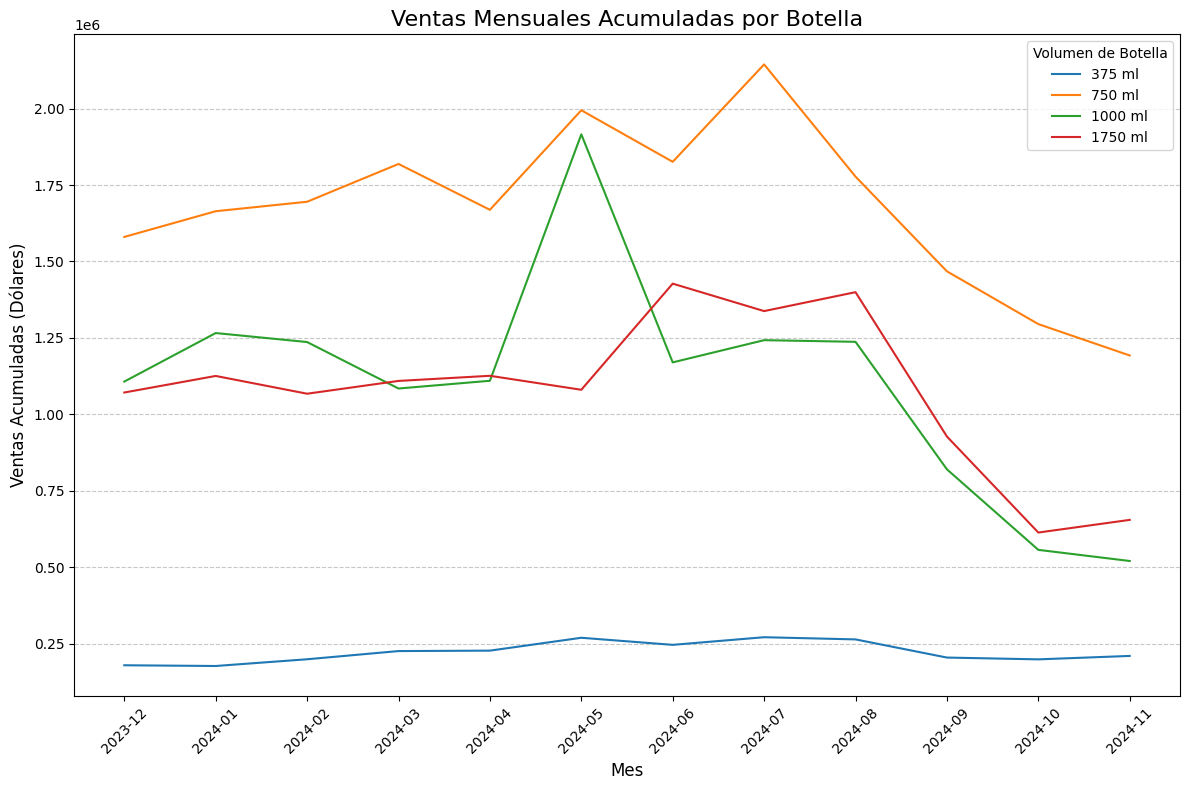

In [10]:
import matplotlib.pyplot as plt

# Crear una columna para el mes a partir de la fecha
df_acumulado['month'] = pd.to_datetime(df_acumulado['sale_date']).dt.to_period('M')

# Agrupar por mes y volumen de botella para calcular las ventas acumuladas
ventas_mensuales = df_acumulado.groupby(['month', 'Bottle Volume (ml)'])['Sale (Dollars)'].sum().reset_index()

# Configurar el gráfico
plt.figure(figsize=(12, 8))

# Iterar sobre cada botella para crear una línea en el gráfico
for volumen in ventas_mensuales['Bottle Volume (ml)'].unique():
    data_filtrada = ventas_mensuales[ventas_mensuales['Bottle Volume (ml)'] == volumen]
    plt.plot(data_filtrada['month'].astype(str), data_filtrada['Sale (Dollars)'], label=f'{volumen} ml')

# Personalizar el gráfico
plt.title('Ventas Mensuales Acumuladas por Botella', fontsize=16)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Ventas Acumuladas (Dólares)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Volumen de Botella')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [11]:
df_acumulado.columns

Index(['sale_date', 'Bottle Volume (ml)', 'Sale (Dollars)',
       'State Bottle Cost', 'State Bottle Retail', 'month'],
      dtype='object')

### Agregar variables

In [16]:
# Crear nuevas características basadas en la fecha
df_acumulado['year'] = df_acumulado['sale_date'].dt.year
df_acumulado['month'] = df_acumulado['month'].dt.month
df_acumulado['day'] = df_acumulado['sale_date'].dt.day
df_acumulado['weekday'] = df_acumulado['sale_date'].dt.weekday

# Rellenar valores nulos en la columna de ventas (si los hay)
df_acumulado['Sale (Dollars)'] = df_acumulado['Sale (Dollars)'].fillna(df_acumulado['Sale (Dollars)'].median())

# Guardar el dataset agrupado en un archivo CSV (opcional)
output_file_acumulado = "dataset_acumulado_pre_ml.csv"
df_acumulado.to_csv(output_file_acumulado, index=False)
print(f"El dataset acumulado ha sido guardado como: {output_file_acumulado}")

El dataset acumulado ha sido guardado como: dataset_acumulado_pre_ml.csv


In [13]:
import sklearn
print(sklearn.__version__)

1.6.0


### Machine Learning

In [23]:
df_acumulado = pd.read_csv("dataset_acumulado_pre_ml.csv")

Error cuadrático medio (MSE): 51787120.84


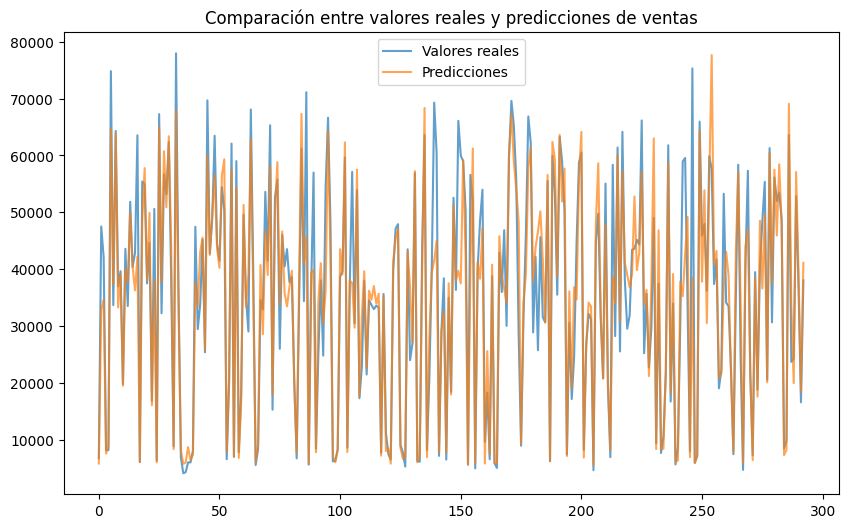

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Selección de características y variable objetivo
features = [
    'month', 'day', 'weekday', 
    'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail'
]
target = 'Sale (Dollars)'

# Dividir X (características) e y (objetivo)
X = df_acumulado[features]
y = df_acumulado[target]

# Dividir en conjunto de entrenamiento y prueba (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características con StandardScaler
scaler = StandardScaler()

# Ajustar el escalador SOLO con el conjunto de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar la transformación al conjunto de prueba
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo con MSE (Error Cuadrático Medio)
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio (MSE): {mse:.2f}")

# Comparar predicciones con los valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Valores reales", alpha=0.7)
plt.plot(y_pred, label="Predicciones", alpha=0.7)
plt.legend()
plt.title("Comparación entre valores reales y predicciones de ventas")
plt.show()




In [28]:
# Contar la cantidad de valores únicos en la columna 'Bottle Volume (ml)'
conteo_volumen = df_completo['Bottle Volume (ml)'].value_counts()

# Mostrar el conteo de valores únicos
print("Conteo de valores para 'Bottle Volume (ml)':")
print(conteo_volumen)

# Si necesitas un resumen de las frecuencias, también puedes ver las estadísticas básicas
print("\nResumen de las frecuencias:")
print(conteo_volumen.describe())


Conteo de valores para 'Bottle Volume (ml)':
Bottle Volume (ml)
750      195729
1750      89175
1000      62703
375       42887
500       18624
200       15301
600        4920
300        2253
3000       2053
100        1362
800         504
1200        490
50          188
2400        166
850          65
400          33
900          21
4800         20
3500         20
502          17
6000         17
1125         17
250          15
1850         13
1950         13
150           8
950           6
603           6
301           4
31500         3
1800          2
2250          2
3900          2
1500          1
9000          1
3600          1
Name: count, dtype: int64

Resumen de las frecuencias:
count        36.000000
mean      12128.944444
std       36782.708632
min           1.000000
25%           6.000000
50%          20.000000
75%        1534.750000
max      195729.000000
Name: count, dtype: float64


### Estudio de precios / Dataset proyecciones

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

Promedio total de 'State Bottle Cost' por botella (ml):
Bottle Volume (ml)
375      5.038488
750     10.313452
1000    10.061877
1750    11.598904
Name: State Bottle Cost, dtype: float64

Promedio total de 'State Bottle Retail' por botella (ml):
Bottle Volume (ml)
375      7.558864
750     15.488693
1000    15.095661
1750    17.433348
Name: State Bottle Retail, dtype: float64


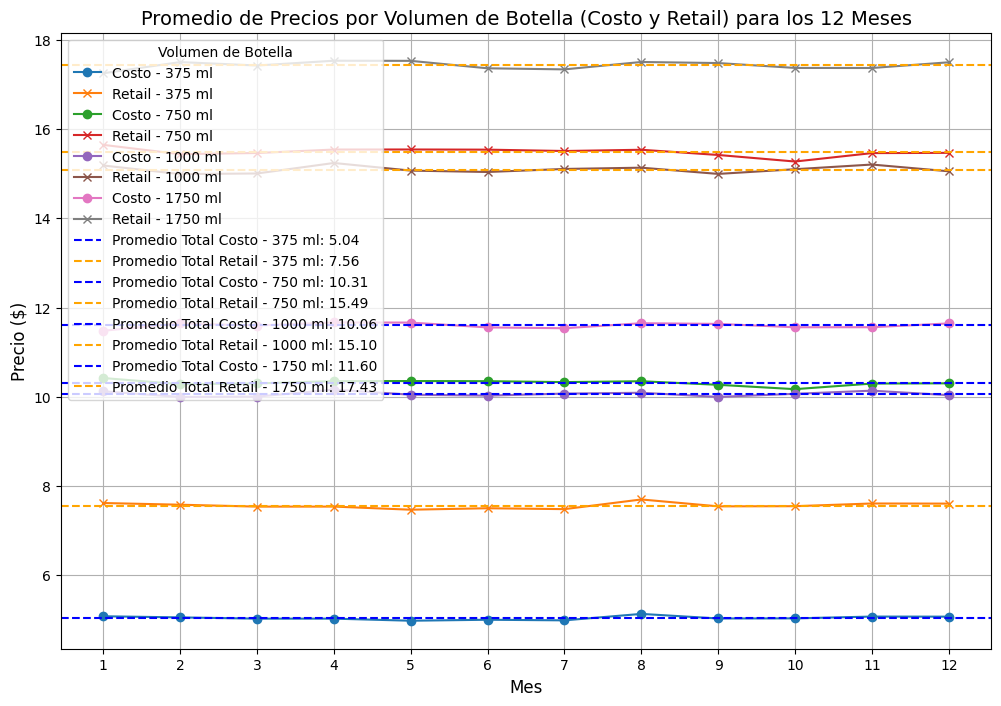

In [33]:
# Filtrar el dataset para trabajar solo con las botellas de interés
botellas_interes = [375, 750, 1000, 1750]
df_filtrado = df_completo[df_completo['Bottle Volume (ml)'].isin(botellas_interes)]

# Agrupar por 'month' y 'Bottle Volume (ml)', y calcular el precio promedio
df_promedio_precio = df_filtrado.groupby(['month', 'Bottle Volume (ml)'])[['State Bottle Cost', 'State Bottle Retail']].mean().reset_index()

# Calcular los promedios totales para cada botella
promedio_total_cost = df_promedio_precio.groupby('Bottle Volume (ml)')['State Bottle Cost'].mean()
promedio_total_retail = df_promedio_precio.groupby('Bottle Volume (ml)')['State Bottle Retail'].mean()

# Mostrar los promedios totales por botella
print("Promedio total de 'State Bottle Cost' por botella (ml):")
print(promedio_total_cost)
print("\nPromedio total de 'State Bottle Retail' por botella (ml):")
print(promedio_total_retail)

# Crear un gráfico para los dos precios
plt.figure(figsize=(12, 8))

# Iterar sobre los diferentes volúmenes de botellas
for volumen in botellas_interes:
    # Filtrar el dataframe para el volumen actual
    df_volumen = df_promedio_precio[df_promedio_precio['Bottle Volume (ml)'] == volumen]
    
    # Graficar los precios de cada volumen
    plt.plot(df_volumen['month'], df_volumen['State Bottle Cost'], label=f'Costo - {volumen} ml', marker='o')
    plt.plot(df_volumen['month'], df_volumen['State Bottle Retail'], label=f'Retail - {volumen} ml', marker='x')

# Graficar los promedios totales por botella
for volumen in botellas_interes:
    plt.axhline(y=promedio_total_cost[volumen], color='blue', linestyle='--', label=f'Promedio Total Costo - {volumen} ml: {promedio_total_cost[volumen]:.2f}')
    plt.axhline(y=promedio_total_retail[volumen], color='orange', linestyle='--', label=f'Promedio Total Retail - {volumen} ml: {promedio_total_retail[volumen]:.2f}')

# Añadir etiquetas y leyenda
plt.title('Promedio de Precios por Volumen de Botella (Costo y Retail) para los 12 Meses', fontsize=14)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Precio ($)', fontsize=12)
plt.xticks(range(1, 13))  # Asegura que los meses estén en el rango correcto (1 a 12)
plt.legend(title='Volumen de Botella', loc='upper left')
plt.grid(True)

# Mostrar el gráfico
plt.show()




In [33]:
# Definir las fechas desde el 1 de diciembre hasta el 28 de febrero
fechas = pd.date_range(start="2024-12-01", end="2025-02-28", freq="D")

# Definir los volúmenes de las botellas y los precios
botellas = [
    {'volume': 375, 'cost': 5.0, 'retail': 7.5},
    {'volume': 750, 'cost': 10.0, 'retail': 15.5},
    {'volume': 1000, 'cost': 10.0, 'retail': 15.0},
    {'volume': 1750, 'cost': 11.5, 'retail': 17.5}
]

# Crear una lista para almacenar los registros
data = []

# Generar los registros para cada día y cada botella
for fecha in fechas:
    for botella in botellas:
        data.append({
            'month': fecha.month,
            'day': fecha.day,
            'weekday': fecha.weekday(),  # Lunes=0, Domingo=6
            'Bottle Volume (ml)': botella['volume'],
            'State Bottle Cost': botella['cost'],
            'State Bottle Retail': botella['retail'],
            'sale_date': fecha
        })

# Crear un DataFrame de pandas con los datos
df_predicciones = pd.DataFrame(data)

# Guardar el DataFrame en un archivo CSV
output_file = "predicciones_futuras.csv"
df_predicciones.to_csv(output_file, index=False)

# Verificar las primeras filas del nuevo dataset
print(df_predicciones.head())



   month  day  weekday  Bottle Volume (ml)  State Bottle Cost  \
0     12    1        6                 375                5.0   
1     12    1        6                 750               10.0   
2     12    1        6                1000               10.0   
3     12    1        6                1750               11.5   
4     12    2        0                 375                5.0   

   State Bottle Retail  sale_date  
0                  7.5 2024-12-01  
1                 15.5 2024-12-01  
2                 15.0 2024-12-01  
3                 17.5 2024-12-01  
4                  7.5 2024-12-02  


In [34]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Cargar el dataset de predicciones futuras
df_predicciones_futuras = pd.read_csv("predicciones_futuras.csv")

# Asegurarse de que las columnas 'month', 'day', 'weekday' sean de tipo entero (si no lo son)
df_predicciones_futuras['month'] = df_predicciones_futuras['month'].astype(int)
df_predicciones_futuras['day'] = df_predicciones_futuras['day'].astype(int)
df_predicciones_futuras['weekday'] = df_predicciones_futuras['weekday'].astype(int)

# Selección de las características
features = [
    'month', 'day', 'weekday', 
    'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail'
]

# Obtener las características de las predicciones
X_pred = df_predicciones_futuras[features]

# Escalar las características con el mismo escalador que se usó durante el entrenamiento
X_pred_scaled = scaler.transform(X_pred)

# Hacer las predicciones con el modelo entrenado
predicciones = model.predict(X_pred_scaled)

# Redondear las predicciones a 2 decimales
df_predicciones_futuras['Predicted Sales (Dollars)'] = np.round(predicciones, 2)

# Guardar las predicciones en un nuevo archivo CSV
output_file = "predicciones_con_resultados.csv"
df_predicciones_futuras.to_csv(output_file, index=False)

# Verificar las primeras filas del dataset con las predicciones
print(df_predicciones_futuras[['sale_date', 'Bottle Volume (ml)', 'Predicted Sales (Dollars)']].head())


    sale_date  Bottle Volume (ml)  Predicted Sales (Dollars)
0  2024-12-01                 375                    6241.45
1  2024-12-01                 750                   49245.17
2  2024-12-01                1000                   34932.75
3  2024-12-01                1750                   34680.51
4  2024-12-02                 375                    5819.02


### Unión Datasets

In [35]:
import pandas as pd

# Cargar los dos datasets
df_entrenamiento = pd.read_csv("dataset_acumulado_pre_ml.csv")
df_predicciones = pd.read_csv("predicciones_con_resultados.csv")

# Cambiar el nombre de las columnas de predicciones para que coincidan
df_predicciones = df_predicciones.rename(columns={'Predicted Sales (Dollars)': 'Sale (Dollars)'})

# Añadir una columna para identificar si es dato real (0) o predicción (1)
df_entrenamiento['Prediction'] = 0  # Las ventas reales tendrán valor 0
df_predicciones['Prediction'] = 1  # Las predicciones tendrán valor 1

# Concatenar los dos datasets
df_final = pd.concat([df_entrenamiento[['sale_date', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)', 'Prediction']],
                      df_predicciones[['sale_date', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)', 'Prediction']]])

# Asegurarnos de que las columnas estén en el orden adecuado para Tableau
df_final = df_final[['sale_date', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)', 'Prediction']]

# Convertir 'sale_date' a formato de fecha
df_final['sale_date'] = pd.to_datetime(df_final['sale_date'])

# Guardar el dataset unificado en un archivo CSV
output_file_final = "dataset_unificado.csv"
df_final.to_csv(output_file_final, index=False)

# Verificar las primeras filas del dataset unificado
print(df_final.head())


   sale_date  Bottle Volume (ml)  State Bottle Cost  State Bottle Retail  \
0 2023-12-01                 375               6.06                 9.09   
1 2023-12-01                 750               5.23                 7.84   
2 2023-12-01                1000               7.02                10.53   
3 2023-12-01                1750              13.40                20.10   
4 2023-12-02                 375               4.54                 6.80   

   Sale (Dollars)  Prediction  
0         6713.81           0  
1        49635.49           0  
2        36328.20           0  
3        32135.19           0  
4         6662.66           0  


In [36]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1824 entries, 0 to 359
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   sale_date            1824 non-null   datetime64[ns]
 1   Bottle Volume (ml)   1824 non-null   int64         
 2   State Bottle Cost    1824 non-null   float64       
 3   State Bottle Retail  1824 non-null   float64       
 4   Sale (Dollars)       1824 non-null   float64       
 5   Prediction           1824 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 99.8 KB


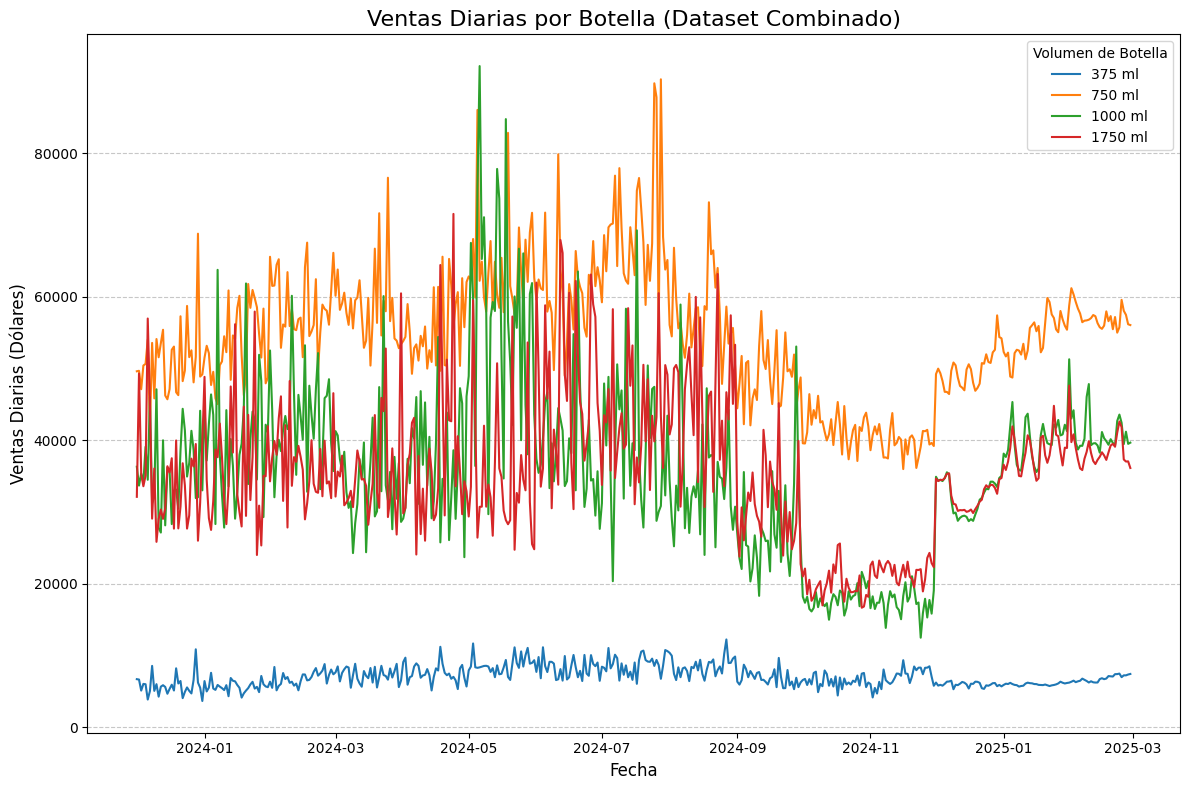

In [37]:
import matplotlib.pyplot as plt

# Asegurarnos de que la columna 'sale_date' sea de tipo fecha
df_final['sale_date'] = pd.to_datetime(df_final['sale_date'])

# Iterar por cada botella para graficar sus ventas diarias
plt.figure(figsize=(12, 8))

for volumen in df_final['Bottle Volume (ml)'].unique():
    # Filtrar los datos para la botella actual
    data_filtrada = df_final[df_final['Bottle Volume (ml)'] == volumen]
    
    # Graficar las ventas diarias para la botella actual
    plt.plot(data_filtrada['sale_date'], data_filtrada['Sale (Dollars)'], label=f'{volumen} ml')

# Personalización del gráfico
plt.title('Ventas Diarias por Botella (Dataset Combinado)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ventas Diarias (Dólares)', fontsize=12)
plt.legend(title='Volumen de Botella')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()
